In [19]:
from scvi.model.utils import mde
import pymde
import scanpy as sc
import scvi
import glob
import os
from functools import reduce
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.io import mmread
import gzip


## Daniel's functions

In [20]:
def read_sc_data(
    counts_file, 
    features_file,
    metadata_file
):
    data_dict = {}
    for key, filename in zip(
        ['counts', 'features', 'metadata'],
        [counts_file, features_file, metadata_file]
    ):
        if filename.endswith('gz'):
            open_file = lambda x: gzip.open(x, 'rt')
            
        else: 
            open_file = lambda x: open(x, 'r')
            
        with open_file(filename) as file:
            if key == 'counts':
                # transpose due to the way the data was exported to comply with Seurat
                # see also convert_to_raw.ipynb
                data = mmread(file).T.tocsr()
            
            elif key == 'metadata':
                data = pd.read_csv(
                    file,
                    sep = '\t',
                    index_col = 0
                )
            
            else:
                data = pd.DataFrame(
                    index = file.read().rstrip().split()
                )
            
        data_dict[key] = data

    adata = ad.AnnData(
        X = data_dict['counts'],
        obs = data_dict['metadata'],
        var = data_dict['features']
    )
    return adata


def compute_qc_metrics(adata):
    # flatten is needed due to csr_matrix.sum returning a numpy.matrix object
    # which cannot be broadcasted to obs frame
    # adata.obs['nFeature_RNA'] = np.array((adata.X > 0).sum(axis = 1)).flatten()
    # adata.obs['nCount_RNA'] = np.array(adata.X.sum(axis = 1)).flatten()
#     adata.obs['percent_mt'] = np.array(
#         adata[:, adata.var.index.str.match('^mt.')].X.sum(axis = 1) / adata.X.sum(axis = 1) * 100
#     ).flatten()

    adata.obs['percent_ribo'] = np.array(
        adata[:, adata.var.index.str.match('^rp[sl]')].X.sum(axis = 1) / adata.X.sum(axis = 1) * 100
    ).flatten()


def apply_qc_thresholds(adata, sample_id_column, sample_thresholds):
    adata.obs['qc_pass'] = True
    for sample_id, thresholds in sample_thresholds.items():
        df = adata.obs.loc[adata.obs[sample_id_column] == sample_id, :]
        feature_qcs = []
        for feature, (lo, hi) in thresholds.items():
            feature_qcs.append(
                df[feature].apply(lambda x: x > lo and x < hi).values
            )
        
        qc_pass = np.all(
            np.vstack(feature_qcs),
            axis = 0
        )
        adata.obs.loc[adata.obs[sample_id_column] == sample_id, 'qc_pass'] = qc_pass


def generate_plots(
    axs, 
    df,
    qc_pass_idx, 
    thresholds = None
):
    # datacols = ['nFeature_RNA', 'percent_mt', 'percent_ribo']
    datacols = ['nFeature_RNA', 'percent_mt']
    hue = ['pass' if x else 'fail' for x in qc_pass_idx] if not all(qc_pass_idx) else None
    palette = {'pass': '#4B72B1', 'fail': 'red'} if hue else None
    for j, datacol in enumerate(datacols):
        sns.histplot(
            x = df.loc[:, datacol],
            ax = axs[0, j],
            hue = hue,
            palette = palette,
            kde = True,
            fill = True
        )
        if thresholds and datacol in thresholds:
            for position in thresholds[datacol]:
                if position:
                    axs[0, j].axvline(
                        position,
                        color = 'k',
                        linewidth = 1
                    )
                
    
    xy = [
        ('nCount_RNA', 'nFeature_RNA'),
        ('nFeature_RNA', 'percent_mt')# ,
        # ('percent_mt', 'percent_ribo')
    ]
    for j, (xcol, ycol) in enumerate(xy): 
        sns.scatterplot(
            x = df.loc[:, xcol],
            y = df.loc[:, ycol],
            ax = axs[1, j],
            hue = hue,
            palette = palette,
            edgecolor = 'k',
            facecolor = None,
            color = None,
            alpha = 0.5
        )
        sns.kdeplot(
            x = df.loc[qc_pass_idx, xcol],
            y = df.loc[qc_pass_idx, ycol],
            ax = axs[1, j],
            color = 'lightblue'
        )
        
        if thresholds:
            for key, plotline in zip(
                [xcol, ycol],
                [axs[1, j].axvline, axs[1, j].axhline]
            ):
                if key in thresholds:
                    for position in thresholds[key]:
                        if position:
                            plotline(
                                position,
                                color = 'k',
                                linewidth = 1
                            )

                            
def plot_qc(
    adata,
    thresholds = None, 
    sample_id_column = None,
    sharex = False
):
    if not sample_id_column:
        fig, axs = plt.subplots(2, 2)
        generate_plots(
            axs,
            adata.obs,
            qc_pass_idx = adata.obs[column_dict['qc_pass']] if 'qc_pass' in adata.obs.columns else [True] * adata.obs.shape[0],
            thresholds = thresholds
        )
        
    else:
        fig, axs = plt.subplots(
            adata.obs[sample_id_column].nunique(), 
            4, 
            sharex = 'col' if sharex else 'none'
        )
        for i, sample_id in enumerate(adata.obs[sample_id_column].unique()):
            tmp_df = adata[adata.obs[sample_id_column] == sample_id, :].obs
            generate_plots(
                axs[i, :].reshape(2, 2),
                tmp_df,
                qc_pass_idx = tmp_df['qc_pass'] if 'qc_pass' in tmp_df.columns else [True] * tmp_df.shape[0],
                thresholds = thresholds[sample_id] if thresholds else None
            )
            axs[i, 0].set_ylabel(sample_id)
    
    return fig


def integrate_data_scvi(
    adata, 
    batch_key, 
    categorical_covariate_keys = None,
    continuous_covariate_keys = None,
    use_highly_variable_genes = True,
    n_top_genes = 4000,
    use_gpu = True,
    max_epochs = None,
    train_size = 0.9
    
):
    adata.layers['counts'] = adata.X.copy()
    adata.raw = adata
    
    if use_highly_variable_genes:
        print('computing highly variable genes')
        sc.pp.highly_variable_genes(
            adata,
            n_top_genes = n_top_genes,
            layer = 'counts',
            subset = True,
            flavor = 'seurat_v3',
        )
        
    scvi.model.SCVI.setup_anndata(
        adata,
        layer = 'counts',
        batch_key = batch_key,
        categorical_covariate_keys = categorical_covariate_keys,
        continuous_covariate_keys = continuous_covariate_keys
    )
    # non default parameters from scVI tutorial and scIB github
    # see https://docs.scvi-tools.org/en/stable/tutorials/notebooks/harmonization.html
    # and https://github.com/theislab/scib/blob/main/scib/integration.py
    model = scvi.model.SCVI(
        adata,
        n_layers = 2,
        n_latent = 30,
        gene_likelihood = 'nb'
    )
    model.train(
        use_gpu = use_gpu,
        max_epochs = max_epochs,
        train_size = train_size
    )
    adata.obsm['X_scvi'] = model.get_latent_representation()
    
    print('compute umap from scvi embedding')
    sc.pp.neighbors(
        adata,
        use_rep = 'X_scvi'
    )
    sc.tl.umap(
        adata
    )
    
    return {'data': adata, 'model': model}

## Loading

In [21]:
# Seed for reproducibility
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from typing import Tuple

# scVI imports
import scvi
# from scvi.dataset import AnnDatasetFromAnnData
# from scvi.inference import UnsupervisedTrainer
# from scvi.models.vae import VAE

torch.manual_seed(0)
np.random.seed(0)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from scvi.external import CellAssign

In [23]:
sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

### Reading in final and pilot experiments

In [24]:
bm_final = sc.read_h5ad( "../output/" + "bm_final_singlet.h5ad")
bm_pilot = sc.read_h5ad( "../output/" + "bm_pilot_singlet.h5ad")

In [25]:
bm_final.obs_names_make_unique()
bm_pilot.obs_names_make_unique()

In [26]:
print(bm_final.shape)
print(bm_pilot.shape)

(1550, 14628)
(3968, 15530)


In [27]:
bm_final.X[:5, :5].todense()


matrix([[4., 0., 2., 0., 1.],
        [1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32)

In [28]:
bm_final

AnnData object with n_obs × n_vars = 1550 × 14628
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'RNA_snn_res.0.6', 'seurat_clusters', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'rnaseq_labels', 'immgen_labels'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [29]:
bm_final.obs = bm_final.obs.rename(columns={'percent.mt': 'percent_mt'})
bm_pilot.obs = bm_pilot.obs.rename(columns={'percent.mt': 'percent_mt'})

## Preprocessing - done in R

In [10]:
# min_genes = 0
# min_cells = 3

# sc.settings.verbosity = 2
# sc.pp.filter_cells(bm, min_genes=min_genes)
# sc.pp.filter_genes(bm, min_cells=min_cells)
# sc.pp.filter_cells(bm, min_genes=1)

In [11]:
# mito_genes = bm.var_names.str.startswith("mt-")
# bm.obs["percent_mito"] = (
#     np.sum(bm[:, mito_genes].X, axis=1).A1 / np.sum(bm.X, axis=1).A1
# )
# bm.obs["n_counts"] = bm.X.sum(axis=1).A1

In [12]:
# (bm.obs['percent_mito']).shape

In [13]:
# adata = adata[adata.obs["n_genes"] < 2500, :]
# adata = adata[adata.obs["percent_mito"] < 0.05, :]

In [14]:
# bm.layers["counts"] = bm.X.copy() # preserve counts
# sc.pp.normalize_total(bm, target_sum=1e4)
# sc.pp.log1p(bm)
# bm.raw = bm # freeze the state in `.raw`

## Checking QC

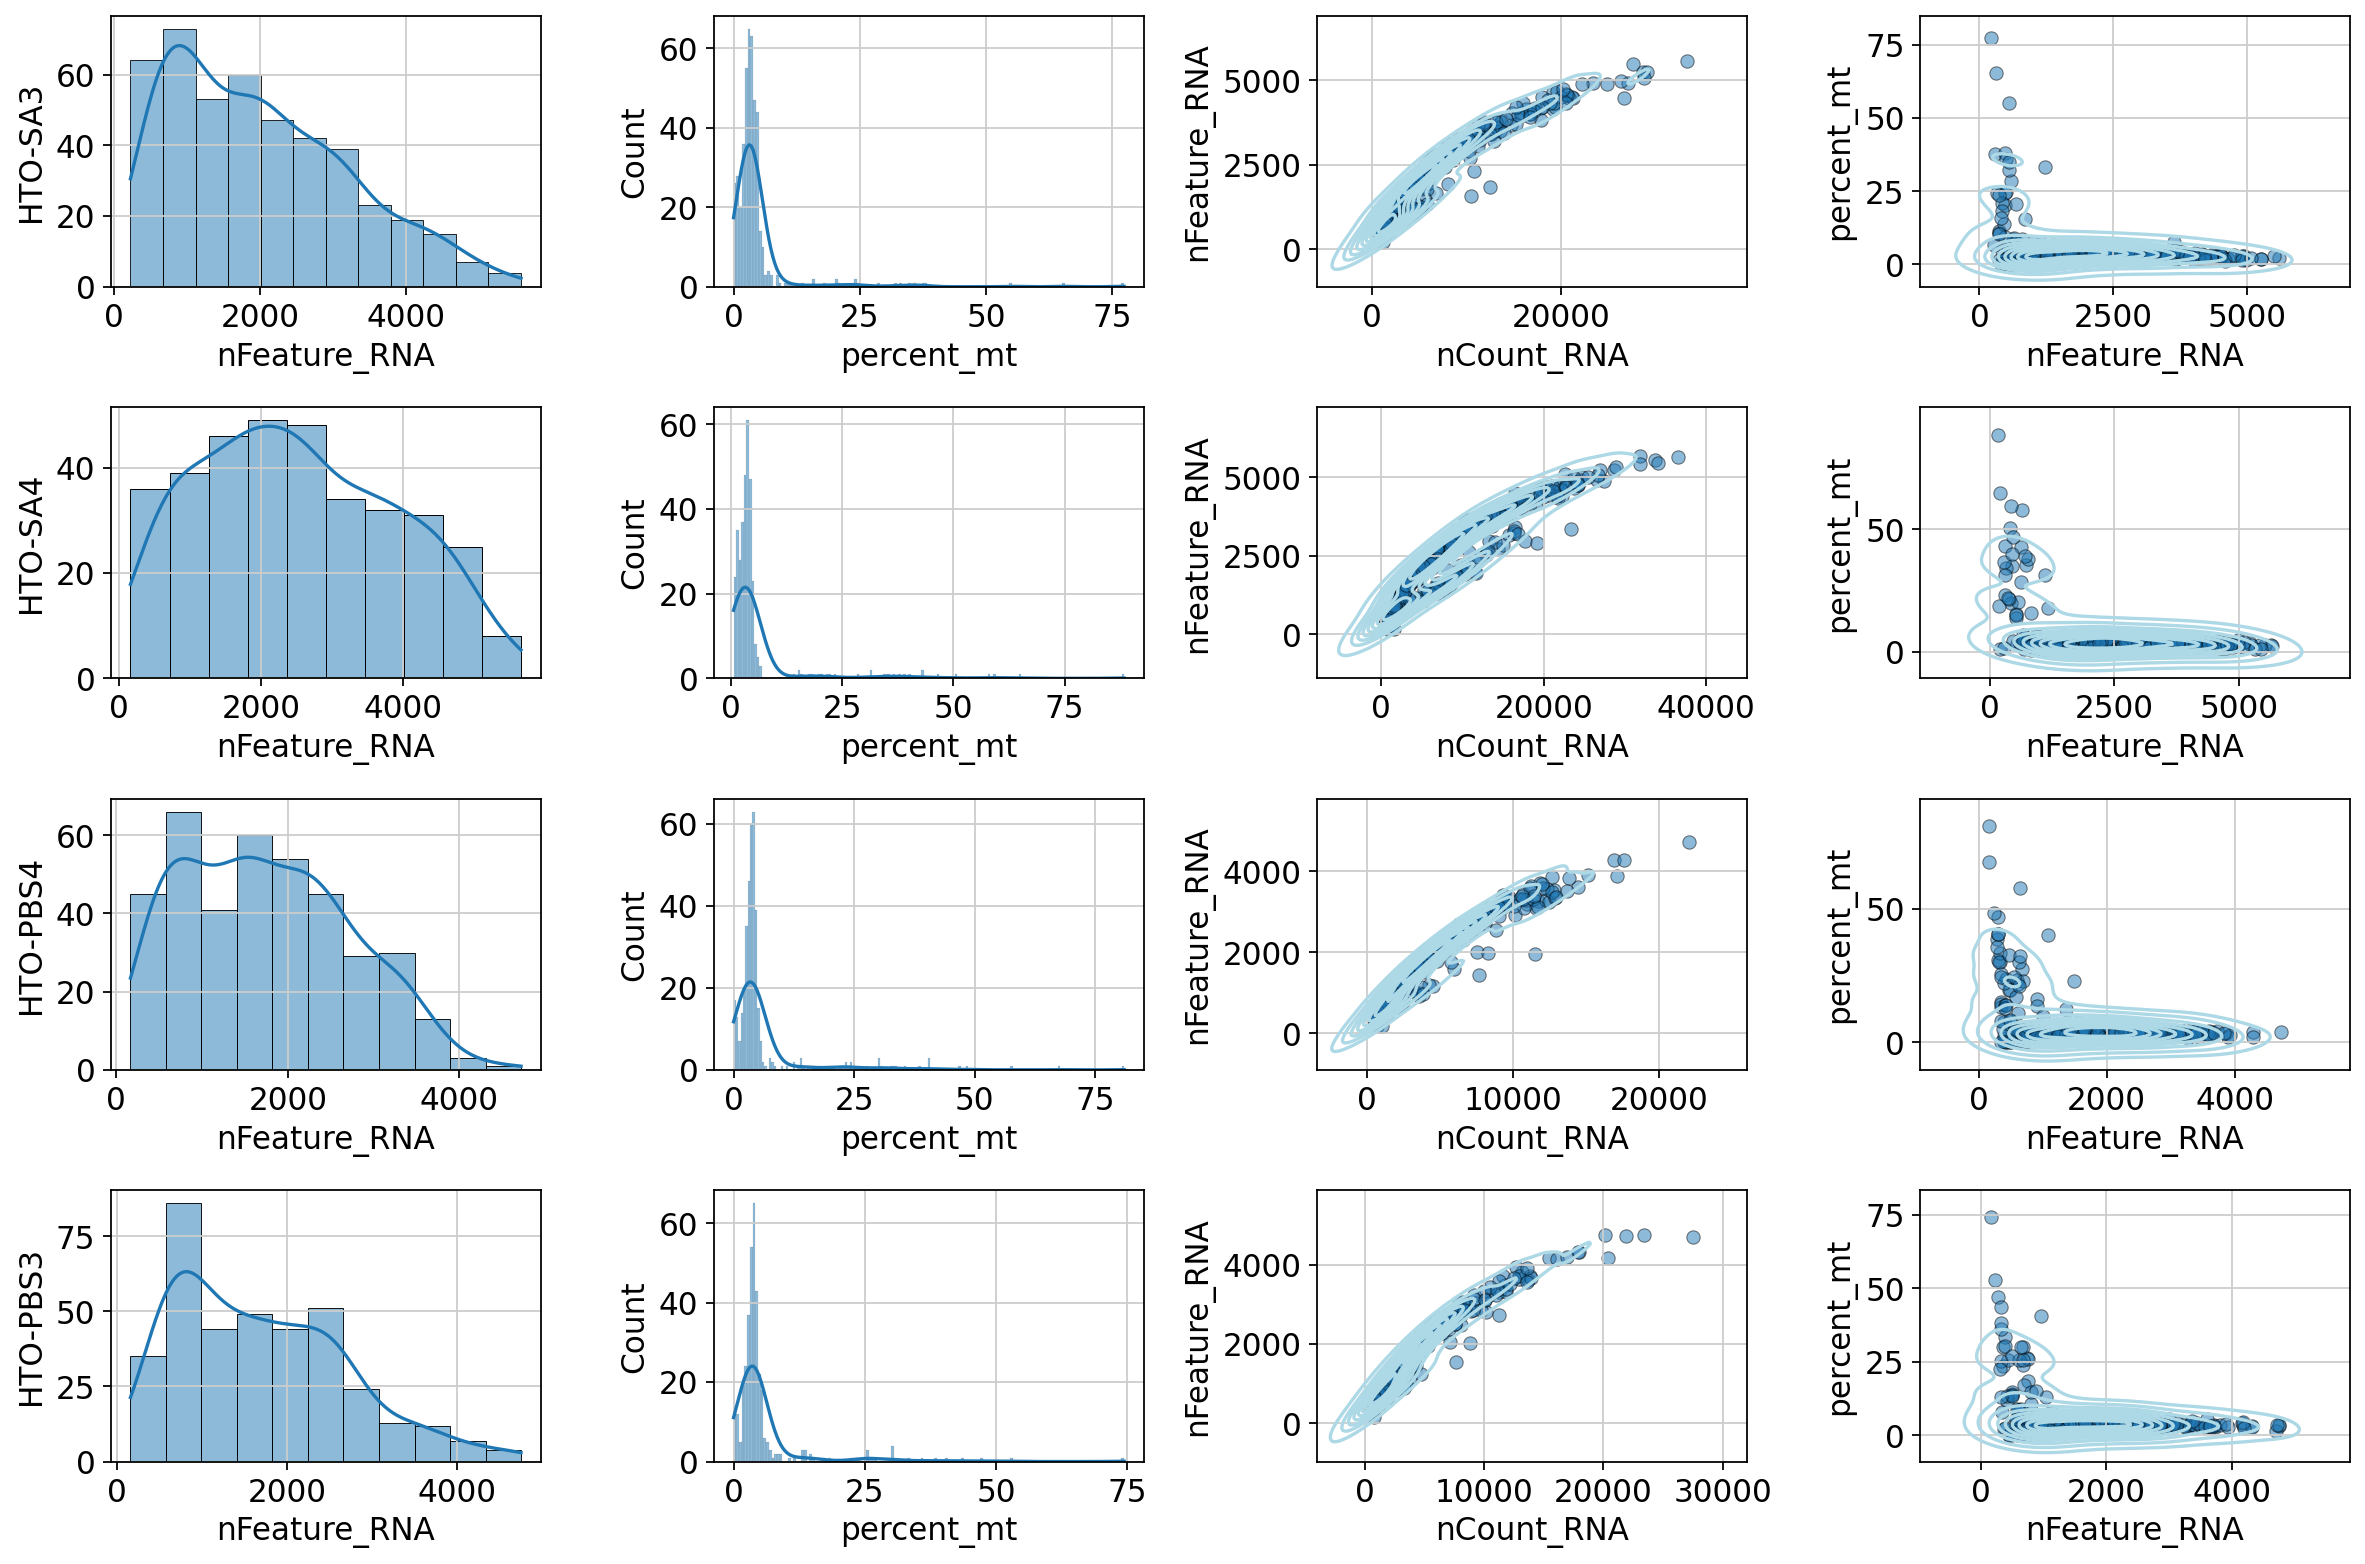

In [18]:
compute_qc_metrics(bm_final)
fig = plot_qc(
    bm_final,
    sample_id_column = 'HTO_maxID'
)
fig.set_figwidth(15)
fig.set_figheight(bm_final.obs.HTO_maxID.nunique() * 2.5)
fig.tight_layout()

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


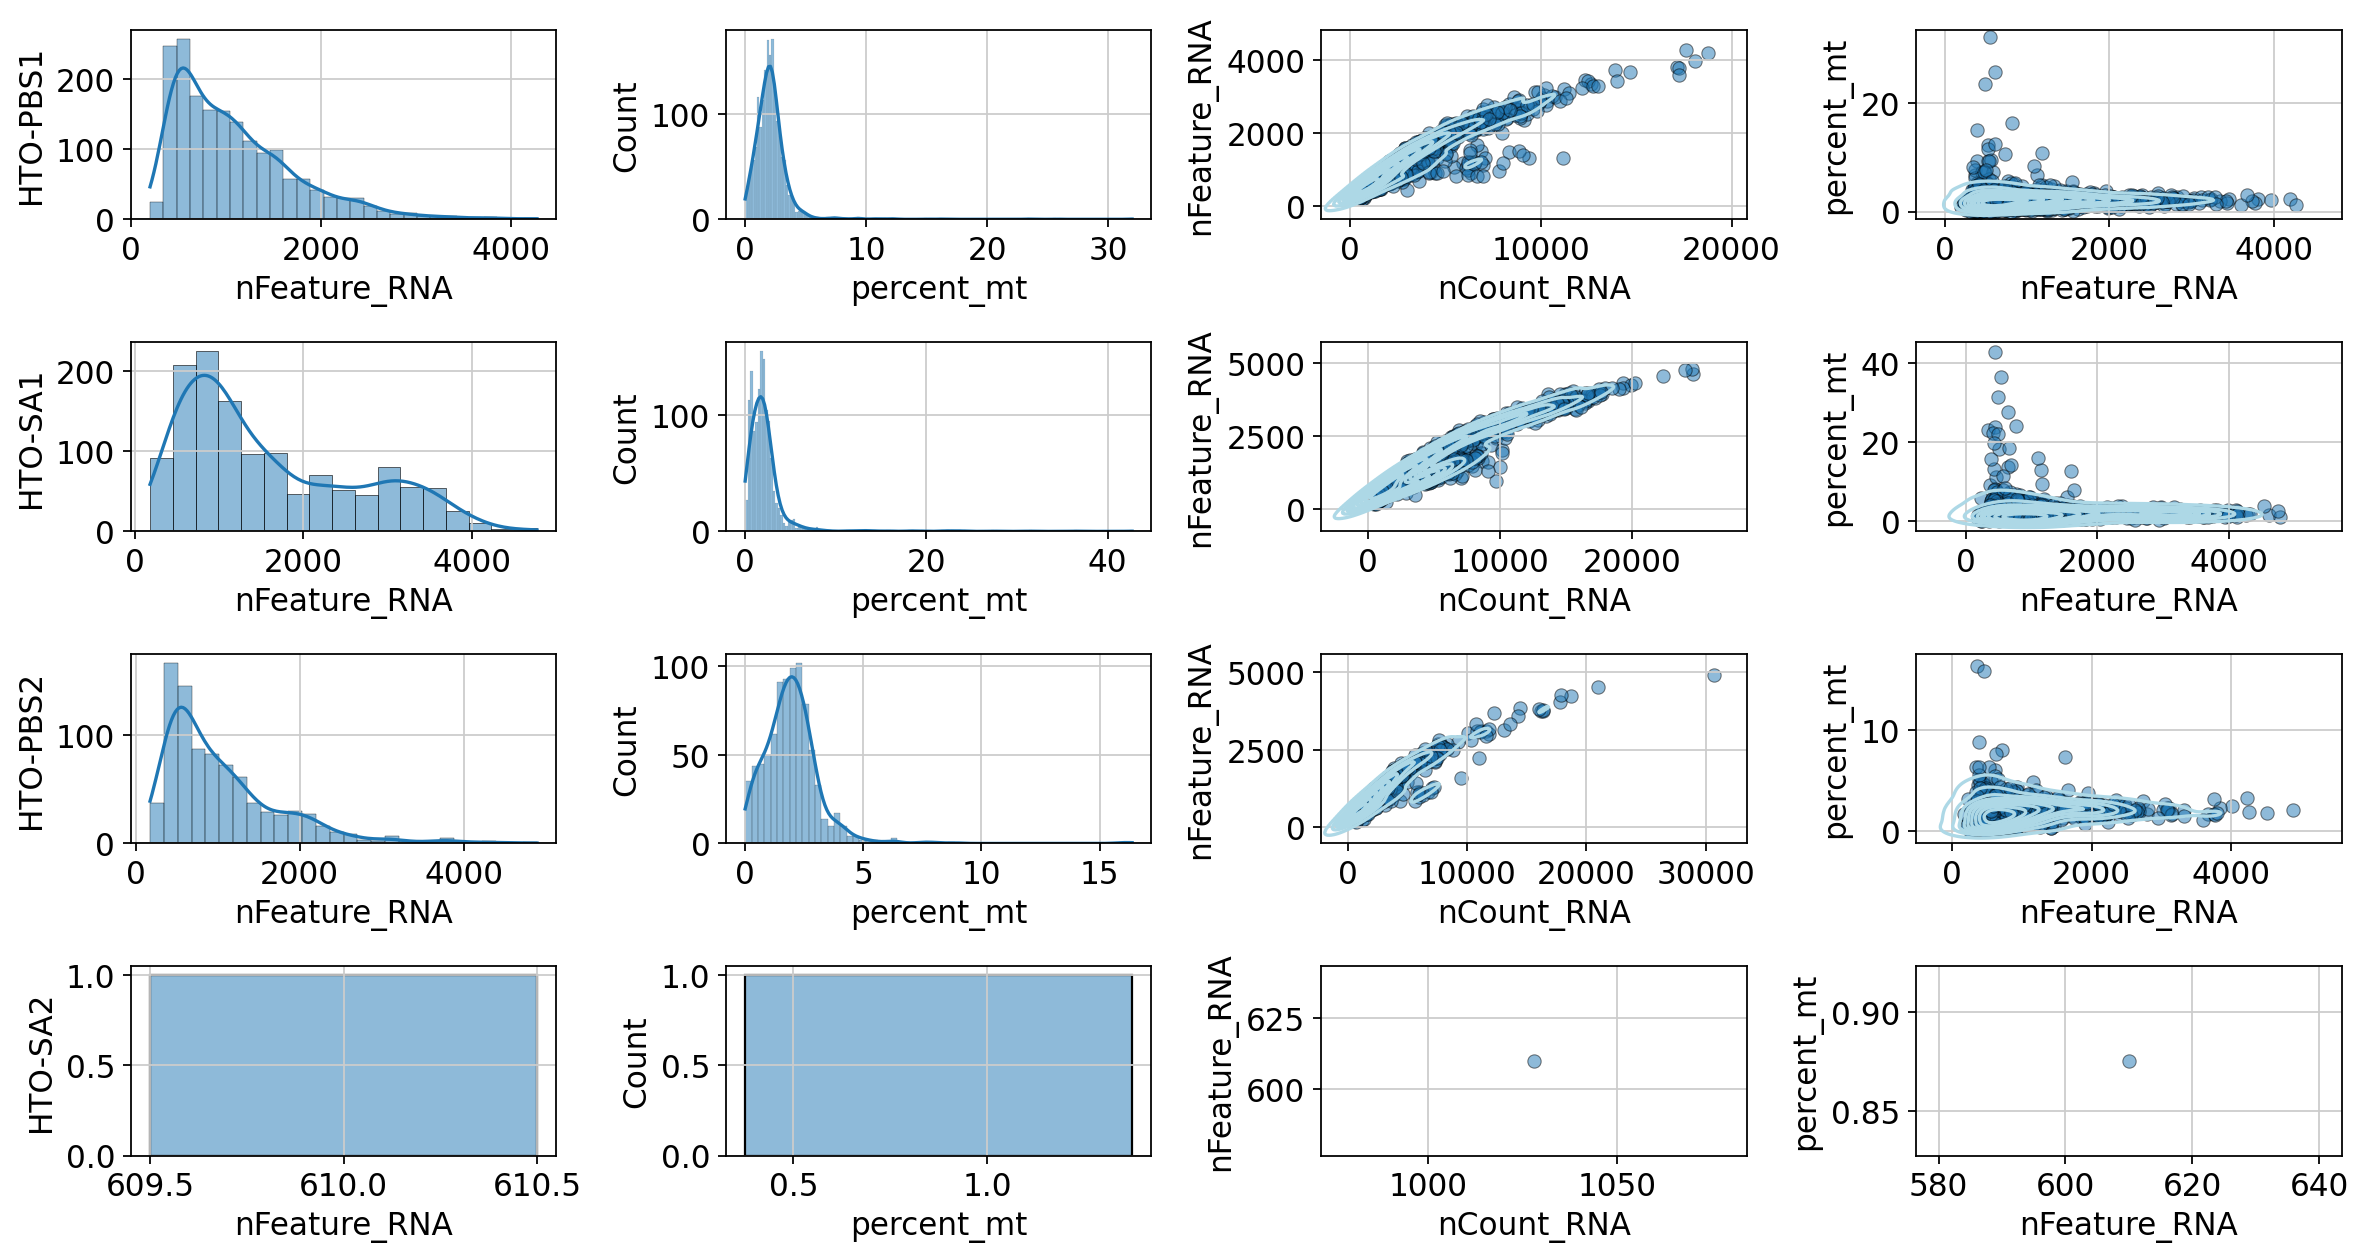

In [19]:
compute_qc_metrics(bm_pilot)
fig = plot_qc(
    bm_pilot,
    sample_id_column = 'HTO_maxID'
)
fig.set_figwidth(15)
fig.set_figheight(bm_final.obs.HTO_maxID.nunique() * 2)
fig.tight_layout()

## Setting up SC

In [30]:
bm_pilot.layers["counts"] = bm_pilot.X.copy()
bm_final.layers["counts"] = bm_final.X.copy()

In [31]:
type(bm_pilot)

anndata._core.anndata.AnnData

## Combining the two datasets with all raw counts

In [32]:
adatas = {
    "pilot": bm_pilot[bm_pilot.obs['HTO_maxID'].isin(['HTO-PBS1', 'HTO-PBS2', 'HTO-SA1'])],
    "final": bm_final
}

In [33]:
bm = ad.concat(adatas, label="batch")

In [34]:
bm.shape

(5517, 14301)

In [35]:
scvi.model.SCVI.setup_anndata(bm, 
                              layer="counts", 
                              batch_key="batch", categorical_covariate_keys=["HTO_maxID"],
    continuous_covariate_keys=["percent_mt"])

In [36]:
vae = scvi.model.SCVI(bm, n_layers=2, n_latent=30, gene_likelihood="nb")

In [37]:
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██| 400/400 [23:46<00:00,  3.56s/it, loss=3.97e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██| 400/400 [23:46<00:00,  3.57s/it, loss=3.97e+03, v_num=1]


In [38]:
bm.raw = bm

In [39]:
bm.obsm["X_scVI"] = vae.get_latent_representation()

In [40]:
bm.layers["scVI_normalized"] = vae.get_normalized_expression(bm)

In [41]:
bm.layers["scVI_normalized"]

array([[8.7709348e-05, 4.3287033e-05, 1.5163534e-04, ..., 5.9940226e-07,
        1.3194763e-05, 4.6386837e-04],
       [6.6520101e-05, 5.3585067e-05, 1.3928631e-04, ..., 1.9344000e-09,
        1.5469984e-06, 1.5082353e-04],
       [7.2585904e-06, 1.4655904e-05, 2.4575125e-05, ..., 2.5489914e-08,
        1.6076839e-08, 1.5231985e-05],
       ...,
       [1.0595716e-05, 2.4082827e-05, 7.5883254e-05, ..., 3.0035758e-07,
        9.7124342e-08, 1.6683430e-04],
       [9.2358270e-05, 4.0701208e-05, 9.6622280e-05, ..., 2.5688200e-07,
        9.7035968e-07, 2.6383478e-04],
       [5.2236825e-05, 4.7815651e-05, 5.6401113e-05, ..., 5.6357831e-06,
        1.1120779e-10, 4.2959626e-04]], dtype=float32)

In [42]:
bm.shape

(5517, 14301)

In [43]:
np.max(bm.layers["scVI_normalized"], axis = 1)

array([0.01905104, 0.01126414, 0.1740188 , ..., 0.05110198, 0.0271033 ,
       0.04854968], dtype=float32)

In [44]:
sc.pp.neighbors(bm, use_rep="X_scVI")
sc.tl.leiden(bm)

2023-02-12 19:43:17.665896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /users/anna.hakobyan/centos/usr/lib:/users/anna.hakobyan/centos/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64


In [35]:
bm.obsm["X_mde"] = mde(bm.obsm["X_scVI"])

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/torch/_lobpcg.py:946: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Rinv = torch.triangular_solve(Id, R, upper=True).solution


In [36]:
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(8, 6), facecolor='white')  # low dpi (dots per inch) yields small inline figures

In [1]:
sc.pl.embedding(
    bm,
    basis="X_mde",
    color=["batch", "leiden", "HTO_maxID"],
    frameon=False,
    ncols=2,
)

NameError: name 'sc' is not defined

In [38]:
# # run PCA then generate UMAP plots
# bm.raw = bm
# sc.pp.scale(bm)
# sc.tl.pca(bm)
# sc.pp.neighbors(bm, n_pcs=30, n_neighbors=20)
# sc.pl.umap(
#     bm,
#     color=["batch", "leiden", "HTO_maxID"],
#     frameon=False,
#     ncols=2,
# )

## Combining cells based on highly variable genes

In [7]:
marker_genes = pd.read_csv('../output/markers_pivot.tsv', sep = "\t", index_col = 0)
marker_genes.head()

B Cells  Basophils  Dendritic Cells  Eosinophils  \
Cd79a        1          0                0            0   
Cd79b        1          0                0            0   
Ighm         1          0                0            0   
Mzb1         0          0                0            0   
Ly6d         1          0                0            0   

       Erythroid-Like And Erythroid Precursor Cells  Gamma Delta T Cells  \
Cd79a                                             0                    0   
Cd79b                                             0                    0   
Ighm                                              0                    0   
Mzb1                                              0                    0   
Ly6d                                              0                    0   

       Hematopoietic Stem Cells  Macrophages  Mast Cells  Monocytes  ...  \
Cd79a                         0            0           0          0  ...   
Cd79b                         0            0           0          0  ...   
Ighm                          0            0           0          0  ...   
Mzb1                          0            0           0          0  ...   
Ly6d                          0            0           0          0  ...   

       Nuocytes  Osteoblasts  Osteoclasts  Plasma Cells  \
Cd79a         0            0            0             0   
Cd79b         0            0            0             0   
Ighm          0            0            0             1   
Mzb1          0            0            0             1   
Ly6d          0            0            0             0   

       Plasmacytoid Dendritic Cells  Platelets  Red Pulp Macrophages  T Cells  \
Cd79a                             0          0                     0        0   
Cd79b                             0          0                     0        0   
Ighm                              0          0                     0        0   
Mzb1                              0          0                     0        0   
Ly6d                              0          0                     0        0   

       T Memory Cells  T Regulatory Cells  
Cd79a               0                   0  
Cd79b               0                   0  
Ighm                0                   0  
Mzb1                0                   0  
Ly6d                0                   0  

[5 rows x 22 columns]

In [12]:
hvg_pilot_ = bm_pilot.copy()
hvg_final_ = bm_final.copy()

In [13]:
sc.pp.highly_variable_genes(
    hvg_pilot_,
    n_top_genes=4000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)
sc.pp.highly_variable_genes(
    hvg_final_,
    n_top_genes=4000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

In [14]:
hvg_plus_marker = hvg_pilot_.var_names.union(hvg_final_.var_names).union(marker_genes.index)
len(hvg_plus_marker)

5532

In [15]:
hvg_pilot = bm_pilot[:, hvg_plus_marker.intersection(bm_pilot.var_names)].copy()
hvg_final = bm_final[:, hvg_plus_marker.intersection(bm_final.var_names)].copy()

In [17]:
np.max(hvg_pilot.X, axis = 1).toarray()

array([[ 10.],
       [ 17.],
       [993.],
       ...,
       [ 17.],
       [  6.],
       [ 17.]], dtype=float32)

In [30]:
hvg_pilot.shape

(3968, 5488)

In [31]:
hvg_final.shape

(1550, 5211)

In [32]:
adatas_hvg = {
    "pilot": hvg_pilot[bm_pilot.obs['HTO_maxID'].isin(['HTO-PBS1', 'HTO-PBS2', 'HTO-SA1'])],
    "final": hvg_final
}

In [33]:
hvg = ad.concat(adatas_hvg, label="batch") 

In [34]:
scvi.model.SCVI.setup_anndata(hvg, 
                              layer="counts", 
                              batch_key="batch", categorical_covariate_keys=["HTO_maxID"],
    continuous_covariate_keys=["percent_mt"])

In [35]:
vae_hvg = scvi.model.SCVI(hvg, n_layers=2, n_latent=30, gene_likelihood="nb")

In [36]:
vae_hvg.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 400/400: 100%|███████████████████████████| 400/400 [14:34<00:00,  2.19s/it, loss=1.51e+03, v_num=1]


In [37]:
hvg.raw = hvg

In [38]:
hvg.layers['scVI_normalized'] = vae_hvg.get_normalized_expression(hvg)

In [39]:
hvg.obsm["X_scVI"] = vae_hvg.get_latent_representation()

In [40]:
sc.pp.neighbors(hvg, use_rep="X_scVI")
sc.tl.leiden(hvg)

2022-08-04 19:23:34.542240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /users/anna.hakobyan/centos/usr/lib:/users/anna.hakobyan/centos/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64


In [41]:
hvg.obsm["X_mde"] = mde(hvg.obsm["X_scVI"])

In [42]:
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(8, 6), facecolor='white')  # low dpi (dots per inch) yields small inline figures

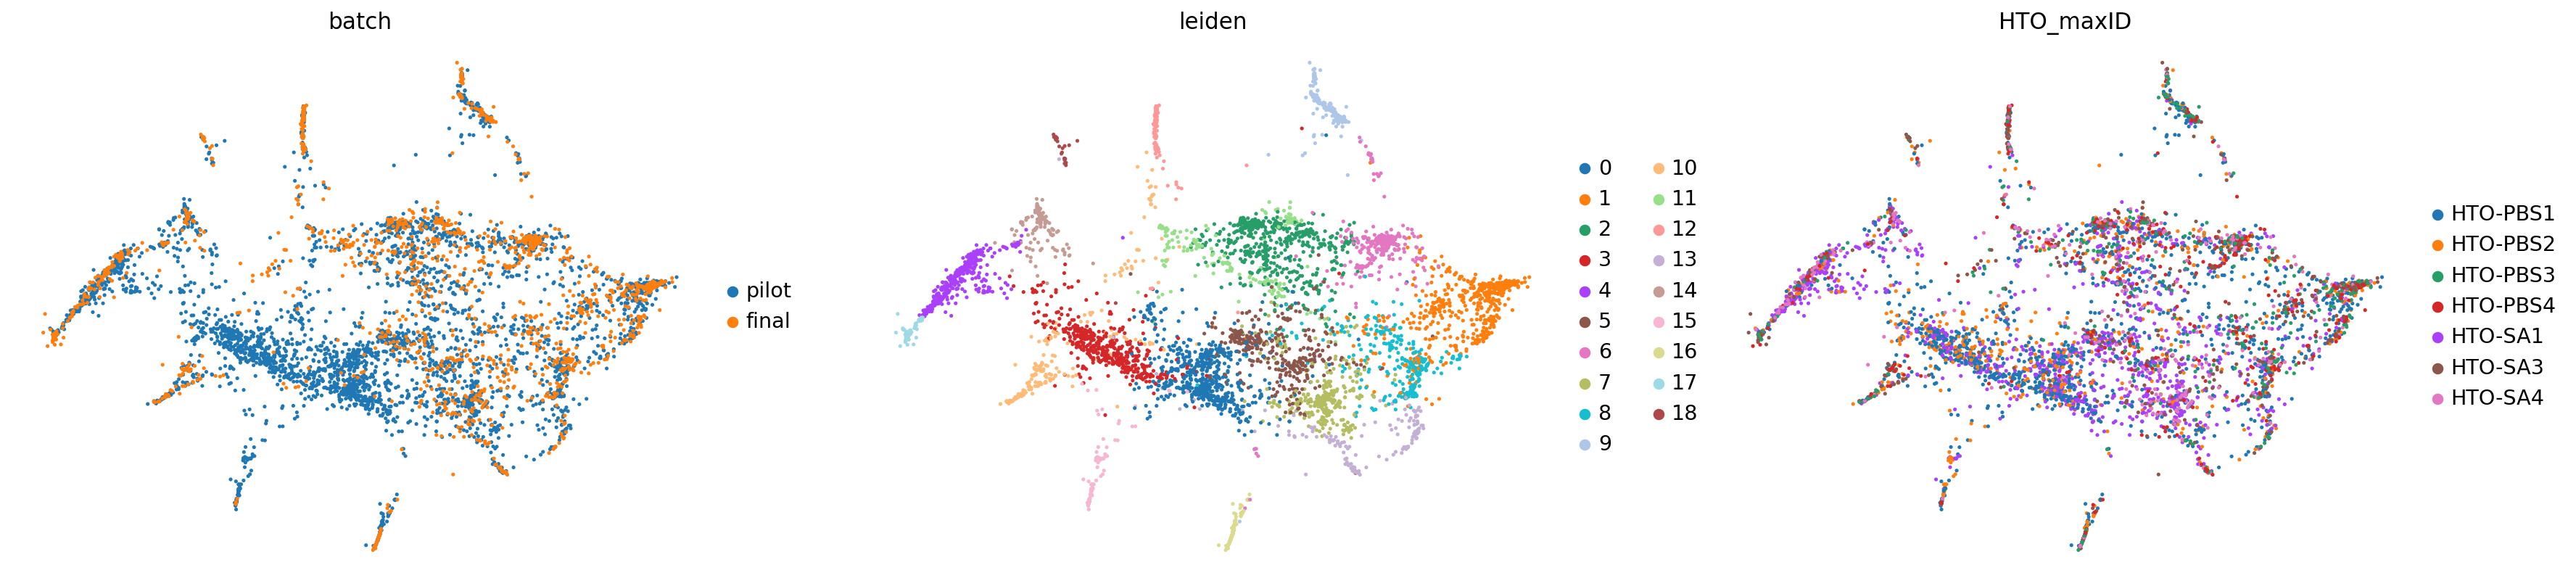

In [43]:
sc.pl.embedding(
    hvg,
    basis="X_mde",
    color=["batch", "leiden", "HTO_maxID"],
    frameon=False,
    ncols=3,
)

## UMAP

#### Running with raw counts

In [36]:
# run PCA then generate UMAP plots
sc.tl.pca(hvg)
sc.pp.neighbors(hvg, n_pcs=30, n_neighbors=20)
sc.tl.umap(hvg, min_dist=0.3)

In [37]:
hvg.obsm

AxisArrays with keys: X_pca, X_tsne, X_umap, _scvi_extra_categorical_covs, _scvi_extra_continuous_covs, X_scVI, X_mde

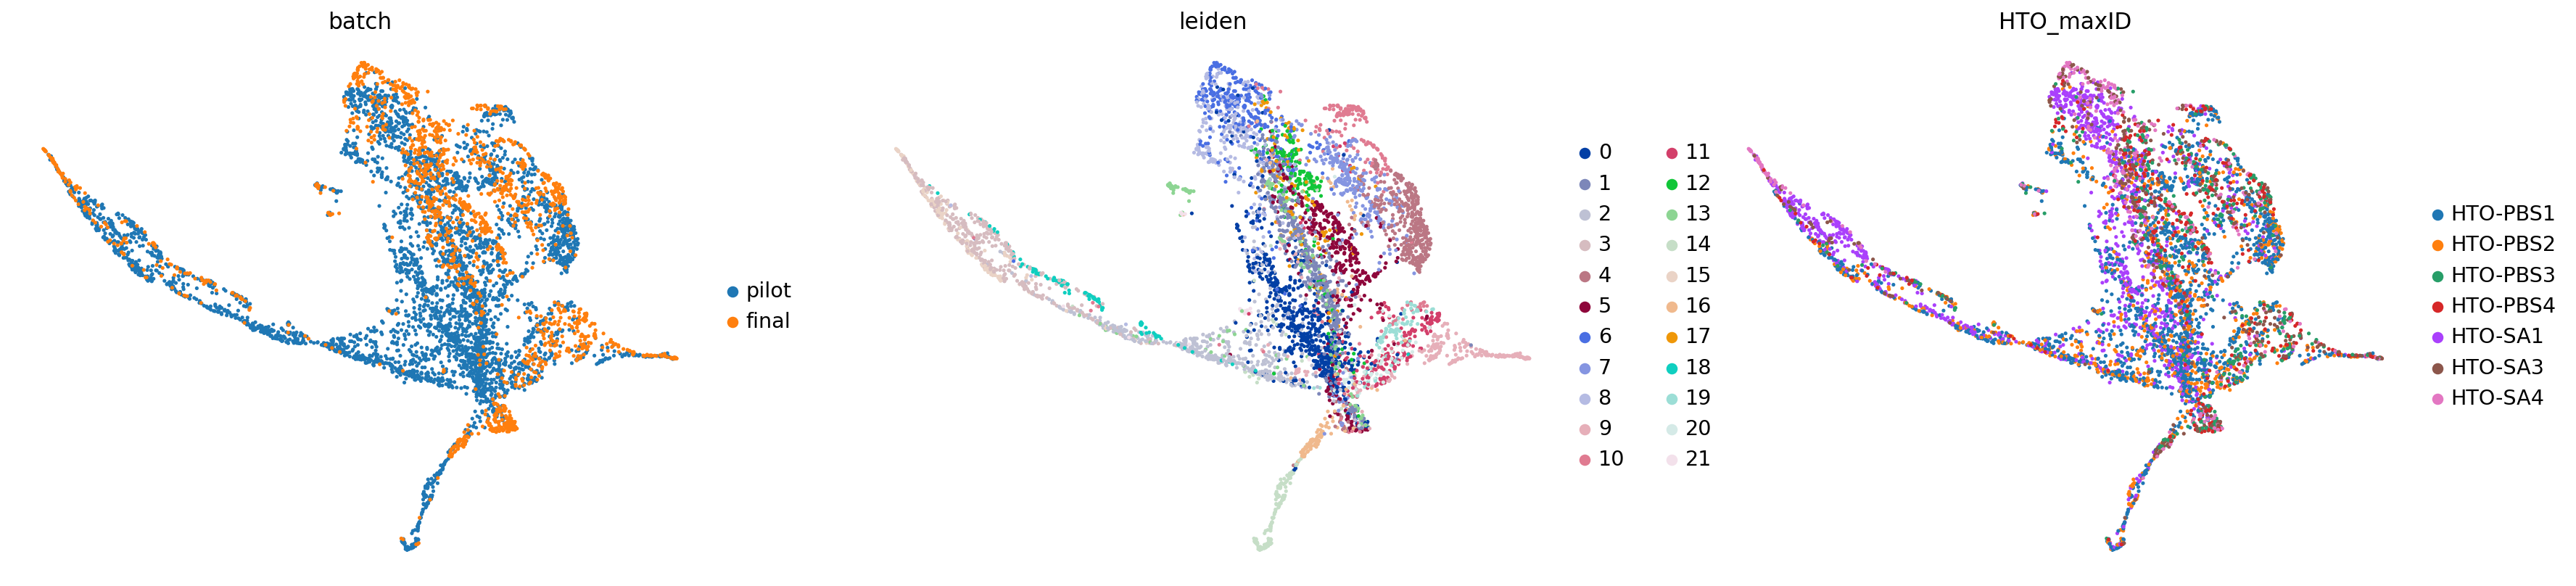

In [38]:
sc.pl.umap(
    hvg,
    color=["batch", "leiden", "HTO_maxID"],
    frameon=False,
    ncols=3,
)

#### Running with scVI latent representation

In [39]:
# run PCA then generate UMAP plots
# sc.tl.pca(hvg)
sc.pp.neighbors(hvg, use_rep = "X_scVI", n_neighbors = 30)
sc.tl.umap(hvg, min_dist=0.3)

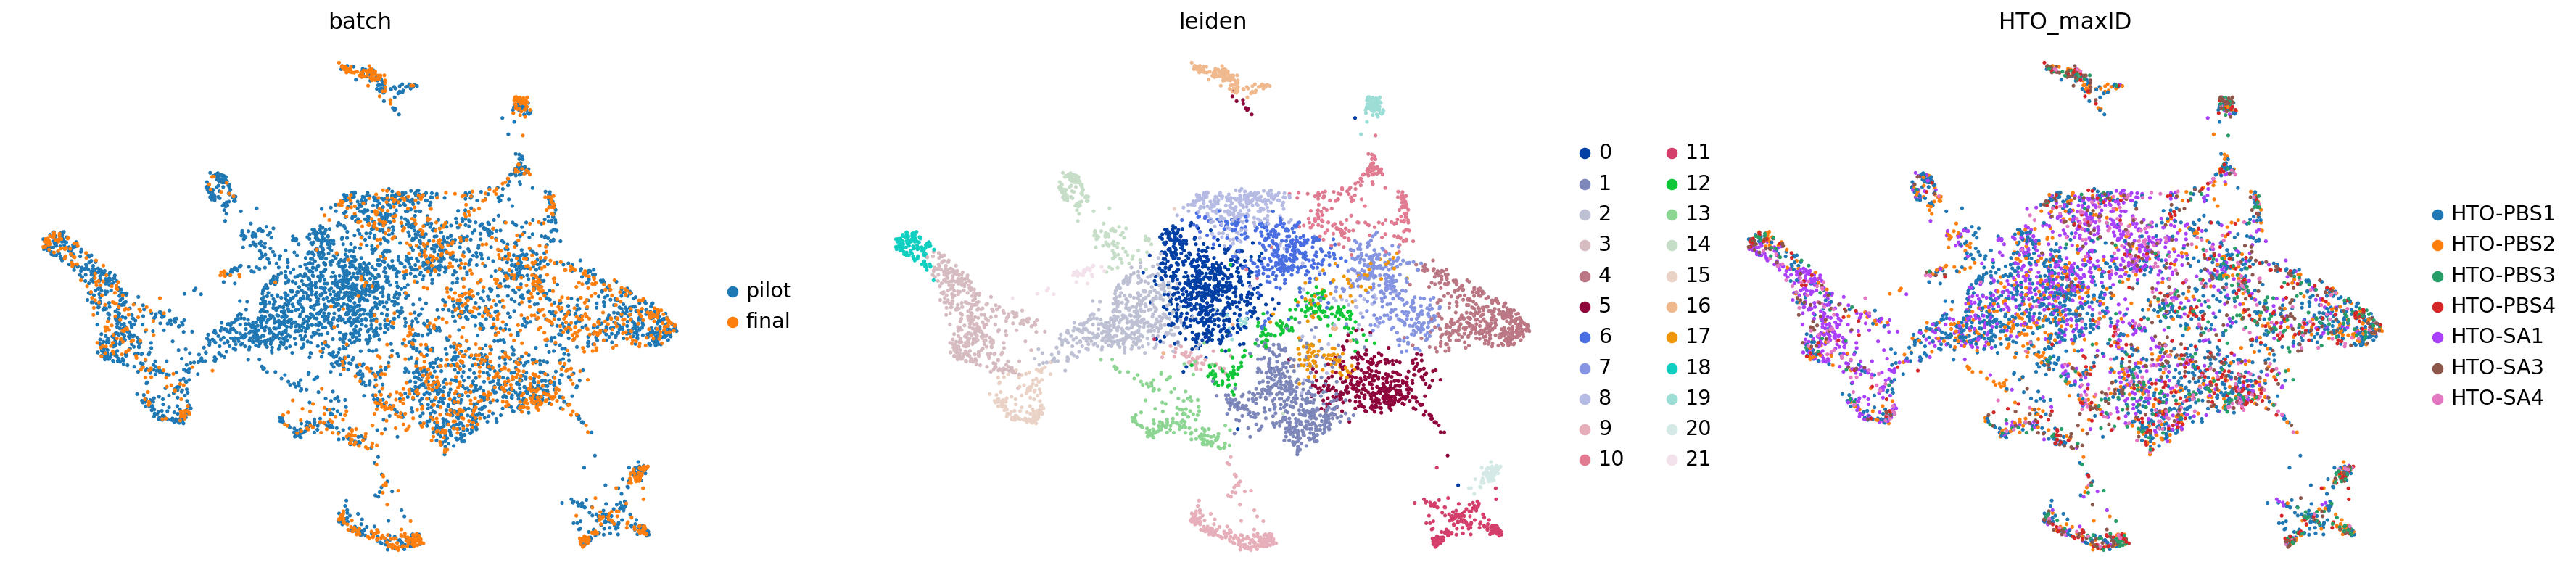

In [40]:
sc.pl.umap(
    hvg,
    color=["batch", "leiden", "HTO_maxID"],
    frameon=False,
    ncols=3,
)

## Saving

In [44]:
sc.pp.normalize_total(hvg, target_sum=1e4)
sc.pp.normalize_total(bm, target_sum=1e4)

NameError: name 'bm' is not defined

In [ ]:
np.sum(hvg.X.todense(), axis = 1)

In [ ]:
hvg.write("../output/hvg_integrated.h5ad")

In [45]:
bm.write("../output/bm_integrated.h5ad")

In [2]:
hvg = sc.read_h5ad("../output/hvg_integrated.h5ad")

In [ ]:
bm.obs

In [ ]:
# %%capture
# def compute_scib_metrics(adata, emb_key, label_key, batch_key, model_name):
#     from scib.metrics.silhouette import silhouette_batch, silhouette
#     from scib.metrics.lisi import lisi_graph
#     import pandas as pd

#     emb_key_ = "X_emb"
#     adata.obsm[emb_key_] = adata.obsm[emb_key]
#     sc.pp.neighbors(adata, use_rep=emb_key_)
#     df = pd.DataFrame(index=[model_name])
#     df["ilisi"], df["clisi"] = lisi_graph(adata, batch_key, label_key, type_="embed")
#     df["sil_batch"] = silhouette_batch(adata, batch_key, label_key, emb_key_)
#     df["sil_labels"] = silhouette(adata, label_key, emb_key_)

#     return df

# emb_key = "X_scVI"
# scvi_metrics = compute_scib_metrics(hvg, emb_key, "cell_type", "batch", "scVI")

### Differential expressions

In [44]:
hvg.obs

nCount_RNA  nFeature_RNA    sample  nCount_HTO  \
AAACCCAAGTCAGGGT-1      2346.0          1215  HTO-PBS1       764.0   
AAACCCACACAAAGCG-1      2399.0          1285  HTO-PBS1       651.0   
AAACCCACAGGATTCT-1      4822.0           916   HTO-SA1       379.0   
AAACCCAGTCTCACGG-1      1267.0           676   HTO-SA1       105.0   
AAACCCAGTTCAGGTT-1      2723.0          1191  HTO-PBS1       925.0   
...                        ...           ...       ...         ...   
TTTGGAGGTAAGTTAG-1     10250.0          3357   HTO-SA4       217.0   
TTTGGAGTCGATTTCT-1      1679.0           882  HTO-PBS4        63.0   
TTTGGTTCAACTGCCG-1      1360.0           780  HTO-PBS4       125.0   
TTTGGTTCACAGCGCT-1      4602.0          2106  HTO-PBS3       323.0   
TTTGTTGAGTATGGCG-1      1044.0           636  HTO-PBS4       229.0   

                    nFeature_HTO HTO_maxID HTO_secondID  HTO_margin  \
AAACCCAAGTCAGGGT-1             3  HTO-PBS1     HTO-PBS2    2.613203   
AAACCCACACAAAGCG-1             3  HTO-PBS1     HTO-PBS2    2.907278   
AAACCCACAGGATTCT-1             3   HTO-SA1     HTO-PBS2    2.448419   
AAACCCAGTCTCACGG-1             3   HTO-SA1     HTO-PBS2    1.431069   
AAACCCAGTTCAGGTT-1             3  HTO-PBS1     HTO-PBS2    3.083565   
...                          ...       ...          ...         ...   
TTTGGAGGTAAGTTAG-1             4   HTO-SA4      HTO-SA3    2.943279   
TTTGGAGTCGATTTCT-1             2  HTO-PBS4     HTO-PBS3    1.956828   
TTTGGTTCAACTGCCG-1             3  HTO-PBS4     HTO-PBS3    1.985128   
TTTGGTTCACAGCGCT-1             4  HTO-PBS3     HTO-PBS4    2.837423   
TTTGTTGAGTATGGCG-1             3  HTO-PBS4     HTO-PBS3    2.756720   

                   HTO_classification   hash.ID  ... percent_mt nCount_SCT  \
AAACCCAAGTCAGGGT-1           HTO-PBS1  HTO-PBS1  ...   2.472293     2288.0   
AAACCCACACAAAGCG-1           HTO-PBS1  HTO-PBS1  ...   2.667778     2327.0   
AAACCCACAGGATTCT-1            HTO-SA1   HTO-SA1  ...   0.476981     2594.0   
AAACCCAGTCTCACGG-1            HTO-SA1   HTO-SA1  ...   4.735596     1886.0   
AAACCCAGTTCAGGTT-1           HTO-PBS1  HTO-PBS1  ...   2.864488     2430.0   
...                               ...       ...  ...        ...        ...   
TTTGGAGGTAAGTTAG-1            HTO-SA4   HTO-SA4  ...   3.892683     4884.0   
TTTGGAGTCGATTTCT-1           HTO-PBS4  HTO-PBS4  ...   1.905896     3977.0   
TTTGGTTCAACTGCCG-1           HTO-PBS4  HTO-PBS4  ...   5.735294     3486.0   
TTTGGTTCACAGCGCT-1           HTO-PBS3  HTO-PBS3  ...   5.063016     4472.0   
TTTGTTGAGTATGGCG-1           HTO-PBS4  HTO-PBS4  ...  20.977011     3370.0   

                    nFeature_SCT  SCT_snn_res.0.8  rnaseq_labels  \
AAACCCAAGTCAGGGT-1          1214                5      Monocytes   
AAACCCACACAAAGCG-1          1285                4      Monocytes   
AAACCCACAGGATTCT-1           731                6   Granulocytes   
AAACCCAGTCTCACGG-1           679                0      Monocytes   
AAACCCAGTTCAGGTT-1          1188                5      Monocytes   
...                          ...              ...            ...   
TTTGGAGGTAAGTTAG-1          2669                1        T cells   
TTTGGAGTCGATTTCT-1           945                3      Monocytes   
TTTGGTTCAACTGCCG-1           955                9        B cells   
TTTGGTTCACAGCGCT-1          2102                2        B cells   
TTTGTTGAGTATGGCG-1           921                4      Monocytes   

                   immgen_labels  batch _scvi_batch _scvi_labels  leiden  
AAACCCAAGTCAGGGT-1    Stem cells  pilot           0            0       2  
AAACCCACACAAAGCG-1       B cells  pilot           0            0       1  
AAACCCACAGGATTCT-1   Neutrophils  pilot           0            0       4  
AAACCCAGTCTCACGG-1     Monocytes  pilot           0            0       0  
AAACCCAGTTCAGGTT-1    Stem cells  pilot           0            0       2  
...                          ...    ...         ...          ...     ...  
TTTGGAGGTAAGTTAG-1    Stem cells  final        

In [45]:
hvg_degs = vae_hvg.differential_expression(
    groupby = "leiden"
)

DE...: 100%|█████████████████████████████████████████████████████████████| 19/19 [00:51<00:00,  2.71s/it]


In [46]:
hvg_degs

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
Cd300e     0.9832        0.0168      4.069433  0.000009  0.000019   
Upk3bl     0.9810        0.0190      3.944133  0.000005  0.000001   
Trpc6      0.9794        0.0206      3.861649  0.000006  0.000015   
Ptn        0.9782        0.0218      3.803804  0.000002  0.000002   
Mogat2     0.9782        0.0218      3.803804  0.000004  0.000005   
...           ...           ...           ...       ...       ...   
Polr2k     0.7348        0.2652      1.019114  0.000341  0.000289   
Psma1      0.7244        0.2756      0.966393  0.000484  0.000458   
Uqcrfs1    0.7164        0.2836      0.926674  0.000475  0.000373   
Arhgdib    0.7090        0.2910      0.890532  0.003283  0.003059   
Cox7c      0.6674        0.3326      0.696449  0.001749  0.001807   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
Cd300e            0.0   0.25  4.322268    4.426519  4.364636  ...   0.004808   
Upk3bl            0.0   0.25  5.416248    5.809442  5.684682  ...   0.003205   
Trpc6             0.0   0.25  3.323146    3.539825  6.568244  ...   0.000000   
Ptn               0.0   0.25  3.936475    4.327382  5.239214  ...   0.003205   
Mogat2            0.0   0.25  2.604776    3.030519  5.676414  ...   0.001603   
...               ...    ...       ...         ...       ...  ...        ...   
Polr2k            0.0   0.25  0.413997    0.199566  1.073428  ...   0.185185   
Psma1             0.0   0.25  0.242644    0.045101  1.018704  ...   0.246914   
Uqcrfs1           0.0   0.25  0.657487    0.274691  1.294525  ...   0.222222   
Arhgdib           0.0   0.25  0.228158    0.116405  0.980761  ...   1.469135   
Cox7c             0.0   0.25  0.147810   -0.137227  0.959648  ...   0.740741   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
Cd300e    0.005927               0.004808               0.003270   
Upk3bl    0.005109               0.003205               0.004292   
Trpc6     0.010014               0.000000               0.008992   
Ptn       0.001022               0.001603               0.001022   
Mogat2    0.009197               0.001603               0.008379   
...            ...                    ...                    ...   
Polr2k    0.487126               0.148148               0.298197   
Psma1     0.715234               0.209877               0.376564   
Uqcrfs1   0.600444               0.160494               0.324687   
Arhgdib   4.708818               0.703704               0.804268   
Cox7c     2.958963               0.456790               0.695364   

         raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
Cd300e               0.114727              0.117356            True   
Upk3bl               0.035670              0.016927            True   
Trpc6                0.000000              0.162079            True   
Ptn                  0.012481              0.016223            True   
Mogat2               0.012559              0.048801            True   
...                       ...                   ...             ...   
Polr2k               3.724748              3.181086           False   
Psma1                6.070447              4.743747           False   
Uqcrfs1              4.543262              3.868599           False   
Arhgdib             34.249958             30.489822           False   
Cox7c               16.221355             18.661877           False   

         comparison  group1 group2  
Cd300e    0 vs Rest       0   Rest  
Upk3bl    0 vs Rest       0   Rest  
Trpc6     0 vs Rest       0   Rest  
Ptn       0 vs Rest       0   Rest  
Mogat2    0 vs Rest       0   Rest  
...             ...     ...    ...  
Polr2k   18 vs Rest      18   Rest  
Psma1    18 vs Rest      18   Rest  
Uqcrfs1  18 vs Rest      18   Rest  
Arhgdib  18 vs Rest      18   Rest  
Cox7c    18 vs Rest      18   Rest  

[98458 rows x 22 columns]

In [56]:
markers = {}
ngenes = 50
cats = hvg.obs.leiden.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = hvg_degs.loc[hvg_degs.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:ngenes]

In [50]:
[len(markers[i]) for i in markers.keys()]

[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

In [49]:
for i in markers.keys():
    if (len(markers[i]) < ngenes):
        for j in range(ngenes - len(markers[i])):
            markers[i].append("")

In [54]:
sc.tl.dendrogram(hvg, groupby="leiden", use_rep="X_scVI")

In [57]:
sc.pl.dotplot(
    hvg,
    markers,
    groupby='leiden',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
    save = 'cluster_markers_dotplot.png'
)

In [58]:
import os
os.getcwd()

'/users/anna.hakobyan/projects/bone_marrow_sc/scripts'

In [80]:
pd.DataFrame(data = markers).fillna(' ').T.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>0</th>\n      <th>1</th>\n      <th>2</th>\n      <th>3</th>\n      <th>4</th>\n      <th>5</th>\n      <th>6</th>\n      <th>7</th>\n      <th>8</th>\n      <th>9</th>\n      <th>10</th>\n      <th>11</th>\n      <th>12</th>\n      <th>13</th>\n      <th>14</th>\n      <th>15</th>\n      <th>16</th>\n      <th>17</th>\n      <th>18</th>\n      <th>19</th>\n      <th>20</th>\n      <th>21</th>\n      <th>22</th>\n      <th>23</th>\n      <th>24</th>\n      <th>25</th>\n      <th>26</th>\n      <th>27</th>\n      <th>28</th>\n      <th>29</th>\n      <th>30</th>\n      <th>31</th>\n      <th>32</th>\n      <th>33</th>\n      <th>34</th>\n      <th>35</th>\n      <th>36</th>\n      <th>37</th>\n      <th>38</th>\n      <th>39</th>\n      <th>40</th>\n      <th>41</th>\n      <th>42</th>\n      <th>43</th>\n      <th>44</th>\n      <th>45</th>\n      <th>46</th>\n      <th>47<

In [51]:
pd.DataFrame(data = markers).fillna(' ').T

0              1         2         3         4          5        6   \
0      Elane           Dmkn     F13a1       Mpo      Ctsg      Prtn3    Ms4a3   
1    Siglech         Ppfia4      Cdh5      Ddr1      Xkrx    Gm34680   Cd300c   
2      Myct1            Hlf   Gm19590      Mycn     Mecom     Nkx2-3    Vldlr   
3        Ngp         S100a9    Wfdc21    Retnlg       Ltf      Cd177     Mmp9   
4   Ifit1bl2  1700047M11Rik     Scrg1     Inhba      Mmp9  Trp53inp2     Fpr2   
5      Elane           Dmkn       Mpo      Nrg1     Ms4a3       Ctsg    Prom1   
6     Arpp21        Gm30948   Slc35d3      Rag1   Tmem121         Ar     Drc7   
7   Hist1h3b        Tmem178  Tctex1d1    Ms4a6d      Nrg1  Hist1h2bm   Ifi211   
8       Mxd3         Ctnnd2    Clec9a  Hist1h3b    Iqgap3      Gtse1     Lifr   
9      Trbc2          Cxcr6    Gimap3       Txk     Trbc1      Skap1     Thy1   
10    Prss50           Aqp1     Sphk1     Tspo2      Klf1     Rec114    Ermap   
11       Mpl        Gucy1a1     Mecom    Cavin2     Myct1      Pcdh7      Gp5   
12     Mcpt8        Cyp11a1   Cd200r3       Il6    Fcer1a      Htr1b    Alox8   
13       Cfh        Cd300lg      Pid1   Clec4a1    S100a4        Fn1    Shtn1   
14      Fcnb         Mogat2   Gm50022      Orm1    Cystm1      Inhba    Cebpe   
15      Igha         Jchain      Igkc     Iglc1  Tnfrsf17      Iglv1    Derl3   
16      Pax5         Vpreb3     Cd79b      Cd19    Akap12      Cd79a  Pou2af1   
17    Retnlg          Il1rn   S100a11    Cstdc4    Clec4d      Csf3r    Mirt2   
18       Ace          Fabp4     Fcgr4   Clec4a3     Adrb1       Hpgd    Gngt2   

           7          8        9   ...         40         41             42  \
0        Ly6d     Fkbp11   Nusap1  ...                                        
1      Sh3bgr       Lifr     Bst2  ...      Pdzd4       Eldr           Tex2   
2      Adgrl4    Afap1l1   Gm5111  ...      Muc13       Car2        Tnfsf10   
3        Lcn2       Camp   S100a8  ...     Nusap1       Ly86           Irf8   
4       Slfn4       Upp1   Asprv1  ...      C5ar1      Cxcr2         Acvrl1   
5    Tctex1d1   Serpine2    F13a1  ...       Mefv                             
6        Dntt     Gimap7     Ctr9  ...       Gbp8     Cox6a2          Sh2d5   
7   Hist1h2af  Hist1h2bj    Trem2  ...   Hist1h3e   Hist1h1a      Hist1h2an   
8   Hist1h2af       Ccnf   Cdc25c  ...  Hist1h2ak  Hist1h2bn        Depdc1a   
9     Gm19585     Sh2d2a  Tcrg-C4  ...        Ltb     Gimap7         Sh2d1a   
10       Rhag       Epor    Mylk3  ...       Car2     Col5a1          Abcb4   
11     Nkx2-3     Rab27b    Mmrn1  ...        Pf4    Afap1l1           Cpa3   
12     Prss34       Cpa3    Rapsn  ...     Igfbp7       Ccr1  E330020D12Rik   
13       Mcub     Lgals3   Ifi207  ...      Slfn5        F10          Plbd1   
14       Ccno      Ncam1     Lipg  ...      Pilra    Clec4a2       Crispld2   
15      Iglc2    Pou2af1    Cd79a  ...      Socs2       Irf4  A430035B10Rik   
16       Ebf1        Cpm    Cplx2  ...      Ikzf3     Fam53b          Iglc1   
17      Il1f9    Gm16556     Mmp9  ...      Tarm1    Gm34084           Ccr1   
18     Adgre4       Cd36    S1pr5  ...      Hmox1     Cd300a        Sh2d1b1   

          43       44       45             46       47             48  \
0                                                                       
1     Kctd12   Srgap3     Blnk         Pmepa1  Tubgcp5        Csf2rb2   
2      Itih5     H1fx   Dipk1b           Dntt    Meis1            Kit   
3       Ccr2     Hmmr                                                   
4    Ankrd22    Plbd1    Chil1          Chil3    Padi4          Adam8   
5                                                                       
6     Ociad2     Gbp4  Ldlrad4          Il1r1   Ctla2a         Il18r1   
7   Hist1h3f    Pira2      Fn1           Mefv    Ifi30           Pif1   
8       Stil     Melk    Pdzd4           Anln    Kif22        Neurl1b   
9        Tox    Il2rg    Klra7           Rora     Xcl1         Il18r1   
10   

In [52]:
pd.DataFrame(data = markers).fillna(' ')

0            1          2         3              4              5  \
0       Elane      Siglech      Myct1       Ngp       Ifit1bl2          Elane   
1        Dmkn       Ppfia4        Hlf    S100a9  1700047M11Rik           Dmkn   
2       F13a1         Cdh5    Gm19590    Wfdc21          Scrg1            Mpo   
3         Mpo         Ddr1       Mycn    Retnlg          Inhba           Nrg1   
4        Ctsg         Xkrx      Mecom       Ltf           Mmp9          Ms4a3   
5       Prtn3      Gm34680     Nkx2-3     Cd177      Trp53inp2           Ctsg   
6       Ms4a3       Cd300c      Vldlr      Mmp9           Fpr2          Prom1   
7        Ly6d       Sh3bgr     Adgrl4      Lcn2          Slfn4       Tctex1d1   
8      Fkbp11         Lifr    Afap1l1      Camp           Upp1       Serpine2   
9      Nusap1         Bst2     Gm5111    S100a8         Asprv1          F13a1   
10       Cd34        Ptprf        Mpl     Chil1          Prok2           Lrg1   
11        Mt1         Upb1      Il1r1    Ifitm6         Ifitm6         Ms4a4c   
12     Cox6a2         Spib      Mdga1      Mmp8          Mmp25         Nusap1   
13     Wfdc21      Pacsin1      Spns2      Fcnb        Stfa2l1          Cebpe   
14  Hist1h2ab         Jaml     Pcp4l1     Chil3  4930438A08Rik          Prtn3   
15       Ccr2         Irf8     Stxbp4      Lrg1           Orm1         Pimreg   
16     Lgals3         Pltp       Rbp1     Cebpe       Ceacam10        Gm1604a   
17      Ahnak        Ccnd1       Mc5r  AA467197           Camp        Slc22a4   
18         Hp      Carmil1      Gata2      Lyz2          Gpr84            Met   
19       Pld4          Kmo      Hmga2    Mcemp1          Mirt2         Papss2   
20     S100a4      Gm21762       Rgs1     Elane          Fcgr4            F10   
21       Sox4          Cd7     Ctla2a   Pglyrp1            Ltf         Fkbp11   
22      Ube2c        Epha2    Ppp1r9a      Ly6d           Fpr1         Cldn15   
23   Hist1h1b        Runx2  Serpina3g    Ctla2a          Tarm1         Mcemp1   
24                  Card11     Angpt1      Dmkn         Abca13           Dio2   
25                   Nucb2     Ctla2b     Ms4a3       Crispld2             C3   
26                    Ccr9    Slc22a3     F13a1           Lrg1           Tfec   
27                    Mycl       Sdsl      Dntt          Dhrs9           H1fx   
28                    Tcf4     Cuedc1        C3          Cd177        Tnfsf13   
29                    Ly6d    Pglyrp2      Ctsg           Lcn2       Hist1h3c   
30                  Atp1b1      Myl10     Anxa1  9830107B12Rik          Itga1   
31                   Mpeg1       Tal1     Rflnb           Lipg           Cd63   
32                   Klrd1      Gng11    Cox6a2        Slco4c1           Hmmr   
33             Arhgap27os2       Cd34    S100a6          Il1r2            Hdc   
34                  Cox6a2     Tbxas1       Mpo         Itgb2l          Bambi   
35                   Fcrla      Gcnt2       Mt1           Ly6g          Kif14   
36                   Itgax      Rab38      Pirb           Mmp8            Mt1   
37                  Rnase6     Adgrg1    Lgals3         Retnlg          Muc13   
38                  Lefty1        Dst  Hist1h1b           Klf5  D130058E05Rik   
39                    Rnd3       Nefh     Prtn3          Anxa1         Adgrl4   
40                   Pdzd4      Muc13    Nusap1          C5ar1           Mefv   
41                    Eldr       Car2      Ly86          Cxcr2                  
42                    Tex2    Tnfsf10      Irf8         Acvrl1                  
43                  Kctd12      Itih5      Ccr2        Ankrd22                  
44                  Srgap3       H1fx      Hmmr          Plbd1                  
45                    Blnk     Dipk1b                    Chil1                  
46                  Pmepa1       Dntt                    Chil3                  
47                 Tubgcp5      Meis1                    Padi4                  
48                 Csf2rb2        Kit      